In [17]:
from gym_idsgame.agents.bot_agents.random_attack_bot_agent import RandomAttackBotAgent
from gym_idsgame.envs import IdsGameRandomAttackV21Env, IdsGameMaximalAttackV21Env
from gym_idsgame.envs.dao.game_config import GameConfig
from gym_idsgame.envs.dao.idsgame_config import IdsGameConfig

# Installazione libreria gym-idsgame
!SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True pip install gym-idsgame

# Creazione dell'ambiente con attaccante casuale
base_game_config = GameConfig()
attacker_agent = RandomAttackBotAgent(game_config=base_game_config, env=None)
idsgame_config = IdsGameConfig(game_config=base_game_config, attacker_agent=attacker_agent)

env_random = IdsGameRandomAttackV21Env(idsgame_config=idsgame_config)
state_size_random = env_random.observation_space.shape[0]
action_size_random = env_random.defender_action_space.n

env_maximal = IdsGameMaximalAttackV21Env(idsgame_config=idsgame_config)
state_size_maximal = env_maximal.observation_space.shape[0]
action_size_maximal = env_maximal.defender_action_space.n

# Algoritmo SARSA

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parametri dell'algoritmo SARSA
alpha = 0.1  # Learning Rate
gamma = 0.99  # Discount Factor
epsilon = 1.0  # Epsilon per la policy Epsilon-Greedy
epsilon_decay = 0.999
epsilon_min = 0.01
episodes_sarsa = 10000

# Inizializzazione della Q-Table
# Lo spazio degli stati è discreto ma vasto, usiamo un dizionario per gestirlo
q_table_sarsa = {}


def get_state_key(state):
    """Converte l'osservazione dello stato in una chiave tupla per il dizionario."""
    return tuple(state.flatten())


def choose_action_sarsa(state_key, q_table):
    """Sceglie un'azione usando una policy epsilon-greedy."""
    if np.random.uniform(0, 1) < epsilon:
        return env_random.defender_action_space.sample()  # Azione esplorativa
    else:
        # Azione greedy (sfruttamento)
        q_values = q_table.get(state_key, np.zeros(action_size_random))
        return np.argmax(q_values)


# Liste per monitorare i risultati
rewards_sarsa = []
steps_sarsa = []

# Ciclo di addestramento
for i in range(episodes_sarsa):
    state = env_random.reset()
    state_key = get_state_key(state[1])
    action = choose_action_sarsa(state_key, q_table_sarsa)

    total_reward = 0
    done = False
    steps = 0

    while not done:
        # Inizializza i valori Q per un nuovo stato se non è presente
        if state_key not in q_table_sarsa:
            q_table_sarsa[state_key] = np.zeros(action_size_random)

        next_state, reward, done, _ = env_random.step((0, action))
        next_state_key = get_state_key(next_state[1])

        # Scegli la prossima azione secondo la policy corrente (on-policy)
        next_action = choose_action_sarsa(next_state_key, q_table_sarsa)

        # Inizializza i valori Q per il prossimo stato se necessario
        if next_state_key not in q_table_sarsa:
            q_table_sarsa[next_state_key] = np.zeros(action_size_random)

        # Aggiornamento della Q-Table con la regola di SARSA
        old_value = q_table_sarsa[state_key][action]
        next_q_value = q_table_sarsa[next_state_key][next_action]

        new_value = old_value + alpha * (reward[1] + gamma * next_q_value - old_value)
        q_table_sarsa[state_key][action] = new_value

        state_key = next_state_key
        action = next_action

        total_reward += reward[1]
        steps += 1

    # Decay di epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    rewards_sarsa.append(total_reward)
    steps_sarsa.append(steps)

    if (i + 1) % 100 == 0:
        print(f"Episodio SARSA: {i + 1}/{episodes_sarsa}, Ricompensa: {total_reward}, Epsilon: {epsilon:.2f}")

Episodio SARSA: 100/10000, Ricompensa: 1, Epsilon: 0.90
Episodio SARSA: 200/10000, Ricompensa: 1, Epsilon: 0.82
Episodio SARSA: 300/10000, Ricompensa: 1, Epsilon: 0.74
Episodio SARSA: 400/10000, Ricompensa: 1, Epsilon: 0.67
Episodio SARSA: 500/10000, Ricompensa: 1, Epsilon: 0.61
Episodio SARSA: 600/10000, Ricompensa: 1, Epsilon: 0.55
Episodio SARSA: 700/10000, Ricompensa: 1, Epsilon: 0.50
Episodio SARSA: 800/10000, Ricompensa: 1, Epsilon: 0.45
Episodio SARSA: 900/10000, Ricompensa: 1, Epsilon: 0.41
Episodio SARSA: 1000/10000, Ricompensa: 1, Epsilon: 0.37
Episodio SARSA: 1100/10000, Ricompensa: -1, Epsilon: 0.33
Episodio SARSA: 1200/10000, Ricompensa: -1, Epsilon: 0.30
Episodio SARSA: 1300/10000, Ricompensa: 1, Epsilon: 0.27
Episodio SARSA: 1400/10000, Ricompensa: 1, Epsilon: 0.25
Episodio SARSA: 1500/10000, Ricompensa: 1, Epsilon: 0.22
Episodio SARSA: 1600/10000, Ricompensa: 1, Epsilon: 0.20
Episodio SARSA: 1700/10000, Ricompensa: 1, Epsilon: 0.18
Episodio SARSA: 1800/10000, Ricompensa

# Algoritmo DDQN

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import random

# Funzioni di supporto per DDQN
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))


class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))

    def __len__(self):
        return len(self.buffer)


class QNetwork(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        hidden = 512
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, output_dim)
        )

    def forward(self, x):
        return self.net(x)


# Utility per ottenere dimensione stato
def flatten_obs(obs):
    arr = np.asarray(obs, dtype=np.float32).ravel()
    return arr


# Parametri DDQN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ddqn_gamma = 0.99
lr = 0.003
buffer_capacity = 100000
batch_size = 128
target_update_freq = 1000  # passi di training
start_learning_after = 1000  # passi di esperienza prima di iniziare update
train_steps = 10000
max_steps_per_episode = 500

# Epsilon schedule
eps_start = 1.0
eps_end = 0.01
eps_decay_steps = 30_000


def epsilon_by_step(t):
    if t >= eps_decay_steps:
        return eps_end
    frac = t / eps_decay_steps
    return eps_start + (eps_end - eps_start) * frac


# Setup rete per RandomAttack
obs_dim = flatten_obs(env_random.reset()).shape[0]
act_dim = env_random.defender_action_space.n
online_q = QNetwork(obs_dim, act_dim).to(device)
target_q = QNetwork(obs_dim, act_dim).to(device)
target_q.load_state_dict(online_q.state_dict())
optimizer = optim.Adam(online_q.parameters(), lr=lr)
replay = ReplayBuffer(buffer_capacity)


# Funzione per selezione azione epsilon-greedy
def select_action(net, obs, eps):
    if random.random() < eps:
        return random.randrange(act_dim)
    with torch.no_grad():
        s = torch.from_numpy(flatten_obs(obs)).unsqueeze(0).to(device)
        q = net(s)
        return int(q.argmax(dim=1).item())


# Loop di training DDQN su RandomAttack
print("\n[DDQN] Training su RandomAttack (difensore)...")
state = env_random.reset()
train_t = 0
episode_return = 0.0
rewards_ddqn_random = []
for step in range(train_steps):
    eps = epsilon_by_step(train_t)
    action = select_action(online_q, state, eps)
    next_state, r, done, _ = env_random.step((0, action))
    r_d = float(r[1])
    replay.push(flatten_obs(state), action, r_d, flatten_obs(next_state), float(done))
    state = next_state
    episode_return += r_d

    # update
    if len(replay) >= start_learning_after:
        batch = replay.sample(batch_size)
        s = torch.from_numpy(np.stack(batch.state)).float().to(device)
        a = torch.tensor(batch.action, dtype=torch.int64).unsqueeze(1).to(device)
        r_t = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(device)
        ns = torch.from_numpy(np.stack(batch.next_state)).float().to(device)
        d = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1).to(device)

        # Q(s,a)
        q_sa = online_q(s).gather(1, a)
        # DDQN target: a* = argmax_a Q_online(s', a), target = r + gamma*(1-d)*Q_target(s', a*)
        with torch.no_grad():
            next_actions = online_q(ns).argmax(dim=1, keepdim=True)
            q_next = target_q(ns).gather(1, next_actions)
            target = r_t + ddqn_gamma * (1.0 - d) * q_next
        loss = nn.SmoothL1Loss()(q_sa, target)
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(online_q.parameters(), 10.0)
        optimizer.step()

        # Aggiornamento periodico target
        if train_t % target_update_freq == 0:
            target_q.load_state_dict(online_q.state_dict())

    train_t += 1

    if done or (step % max_steps_per_episode == 0 and step > 0):
        # reset episodio
        print(f"Step {step}: return episodio (difensore) = {episode_return:.1f}, eps={eps:.2f}")
        rewards_ddqn_random.append(episode_return)
        state = env_random.reset()
        episode_return = 0.0

print("[DDQN] Training RandomAttack completato.")

# Re-setup rete per MaximalAttack (riuso pesi iniziali o trasferimento opzionale)
obs_dim_ma = flatten_obs(env_maximal.reset()).shape[0]
act_dim_ma = env_maximal.defender_action_space.n

online_q_ma = QNetwork(obs_dim_ma, act_dim_ma).to(device)
target_q_ma = QNetwork(obs_dim_ma, act_dim_ma).to(device)
target_q_ma.load_state_dict(online_q_ma.state_dict())
optimizer_ma = optim.Adam(online_q_ma.parameters(), lr=lr)
replay_ma = ReplayBuffer(buffer_capacity)

print("\n[DDQN] Training su MaximalAttack (difensore)...")
state = env_maximal.reset()
train_t = 0
episode_return = 0.0
rewards_ddqn_maximal = []
for step in range(train_steps):
    eps = epsilon_by_step(train_t)
    action = select_action(online_q_ma, state, eps)
    next_state, r, done, _ = env_maximal.step((0, action))
    r_d = float(r[1])
    replay_ma.push(flatten_obs(state), action, r_d, flatten_obs(next_state), float(done))
    state = next_state
    episode_return += r_d

    if len(replay_ma) >= start_learning_after:
        batch = replay_ma.sample(batch_size)
        s = torch.from_numpy(np.stack(batch.state)).float().to(device)
        a = torch.tensor(batch.action, dtype=torch.int64).unsqueeze(1).to(device)
        r_t = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(device)
        ns = torch.from_numpy(np.stack(batch.next_state)).float().to(device)
        d = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1).to(device)

        q_sa = online_q_ma(s).gather(1, a)
        with torch.no_grad():
            next_actions = online_q_ma(ns).argmax(dim=1, keepdim=True)
            q_next = target_q_ma(ns).gather(1, next_actions)
            target = r_t + ddqn_gamma * (1.0 - d) * q_next
        loss = nn.SmoothL1Loss()(q_sa, target)
        optimizer_ma.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(online_q_ma.parameters(), 10.0)
        optimizer_ma.step()

        if train_t % target_update_freq == 0:
            target_q_ma.load_state_dict(online_q_ma.state_dict())

    train_t += 1

    if done or (step % max_steps_per_episode == 0 and step > 0):
        print(f"Step {step}: return episodio (difensore) = {episode_return:.1f}, eps={eps:.2f}")
        rewards_ddqn_maximal.append(episode_return)
        state = env_maximal.reset()
        episode_return = 0.0


[DDQN] Training su RandomAttack (difensore)...
Step 3: return episodio (difensore) = 1.0, eps=1.00
Step 19: return episodio (difensore) = 1.0, eps=1.00
Step 20: return episodio (difensore) = 1.0, eps=1.00
Step 21: return episodio (difensore) = 1.0, eps=1.00
Step 22: return episodio (difensore) = 1.0, eps=1.00
Step 28: return episodio (difensore) = 1.0, eps=1.00
Step 38: return episodio (difensore) = 1.0, eps=1.00
Step 42: return episodio (difensore) = -1.0, eps=1.00
Step 50: return episodio (difensore) = 1.0, eps=1.00
Step 54: return episodio (difensore) = 1.0, eps=1.00
Step 62: return episodio (difensore) = -1.0, eps=1.00
Step 68: return episodio (difensore) = 1.0, eps=1.00
Step 69: return episodio (difensore) = 1.0, eps=1.00
Step 76: return episodio (difensore) = 1.0, eps=1.00
Step 78: return episodio (difensore) = 1.0, eps=1.00
Step 80: return episodio (difensore) = 1.0, eps=1.00
Step 82: return episodio (difensore) = 1.0, eps=1.00
Step 83: return episodio (difensore) = 1.0, eps=1.

# Analisi Algoritmi SARSA - DDQN

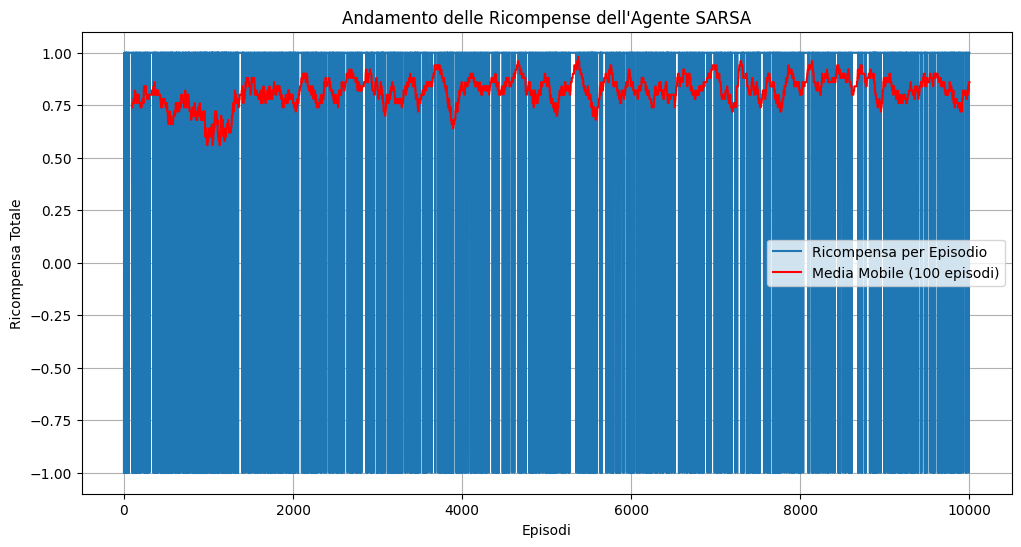

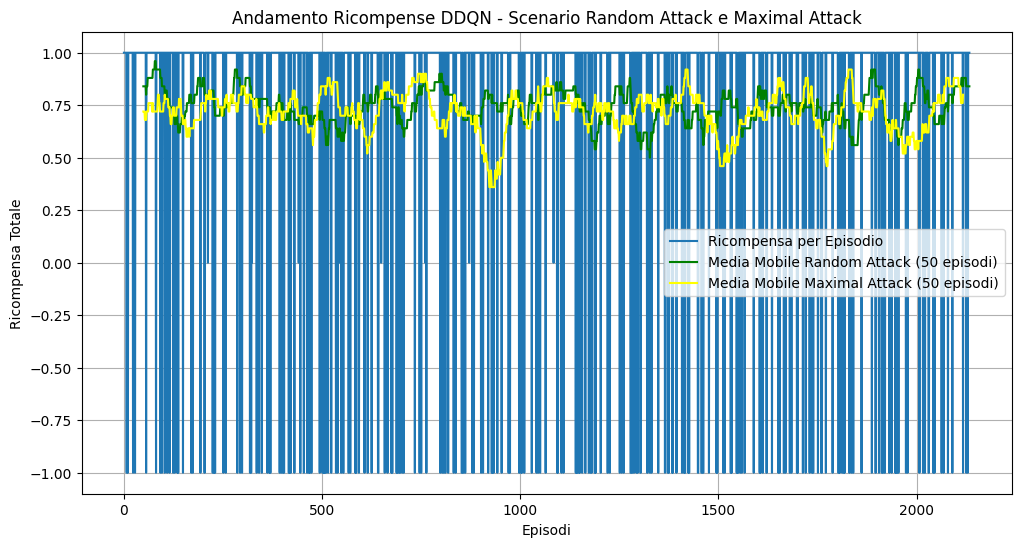

In [20]:
# Calcolo della media mobile per smussare il grafico
moving_avg_sarsa = pd.Series(rewards_sarsa).rolling(100).mean()
moving_avg_ddqn_random = pd.Series(rewards_ddqn_random).rolling(50).mean()
moving_avg_ddqn_maximal = pd.Series(rewards_ddqn_maximal).rolling(50).mean()

# Creazione del grafico per le ricompense dell'Agente SARSA
plt.figure(figsize=(12, 6))
plt.plot(rewards_sarsa, label='Ricompensa per Episodio')
plt.plot(moving_avg_sarsa, label='Media Mobile (100 episodi)', color='red')
plt.title('Andamento delle Ricompense dell\'Agente SARSA')
plt.xlabel('Episodi')
plt.ylabel('Ricompensa Totale')
plt.legend()
plt.grid(True)
plt.show()

# Creazione del grafico per le ricompense dell'Agente DDQN
plt.figure(figsize=(12, 6))
plt.plot(rewards_ddqn_random, label='Ricompensa per Episodio')
plt.plot(moving_avg_ddqn_random, label='Media Mobile Random Attack (50 episodi)', color='green')
plt.plot(moving_avg_ddqn_maximal, label='Media Mobile Maximal Attack (50 episodi)', color='yellow')
plt.title('Andamento Ricompense DDQN - Scenario Random Attack e Maximal Attack')
plt.xlabel('Episodi')
plt.ylabel('Ricompensa Totale')
plt.legend()
plt.grid(True)
plt.show()